# Model Training

### Idea 

Train a classification model using human radiograph images. We will then use class activation mapping to extract heatmaps to help localize any lesions.

For the dataset, labels were extracted from the radiologist report where: blank for unmentioned, 0 for negative, -1 for uncertain, and 1 for positive. See [here](https://stanfordmlgroup.github.io/competitions/chexpert/)

### TODO 

- X Add learning rate scheduler to training. See keras options, and [this](https://www.jeremyjordan.me/nn-learning-rate/) blog post.
- X Add performance analysis
- X Add cutout augmentation as *last* augmentation. Do this in the other training notebook as well
- X Add class weights
- Add Lion optimizer
- Add error analysis
- Add k-fold cross validation
- See what happens if a portion of the model is frozen (e.g. freeze the weights half way through)
- Get heatmap piece at end working, so that you can visualize the argmax class of an image

## Data Processing

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

from typing import List

The code below can be used to verify that the gpu is in use

In [2]:
!nvidia-smi

Fri Jan  5 23:42:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090 Ti     Off | 00000000:01:00.0 Off |                  Off |
|  0%   28C    P8               4W / 450W |    227MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
TARGET_HEIGHT = 640
TARGET_WIDTH = 640

In [4]:
root_directory = '/data/CheXpert-v1.0'

In [5]:
train_folder = os.path.join(root_directory, 'train')
valid_folder = os.path.join(root_directory, 'valid')

In [6]:
train_labels_df = pd.read_csv(os.path.join(root_directory, 'train.csv'))
valid_labels_df = pd.read_csv(os.path.join(root_directory, 'valid.csv'))

In [7]:
train_labels_df.shape

(223414, 19)

In [8]:
valid_labels_df.shape

(234, 19)

In [9]:
chexnet_targets = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

### Uncertainty Approaches
The CheXpert paper outlines several different approaches to mapping using the uncertainty labels in the data:

- Ignoring - essentially removing from the calculation in the loss function
- Binary mapping - sending uncertain values to either 0 or 1
- Prevalence mapping - use the rate of prevelance of the feature as it's target value
- Self-training - consider the uncertain values as unlabeled
- 3-Class Classification - retain a separate value for uncertain and try to predict it as a class in its own right

The paper gives the results of different experiments with the above approaches and indicates the most accurate approach for each feature.
    
|Approach/Feature|Atelectasis|Cardiomegaly|Consolidation|Edema|PleuralEffusion|
|-----------|-----------|-----------|-----------|-----------|-----------|
|`U-Ignore`|0.818(0.759,0.877)|0.828(0.769,0.888)|0.938(0.905,0.970)|0.934(0.893,0.975)|0.928(0.894,0.962)|
|`U-Zeros`|0.811(0.751,0.872)|0.840(0.783,0.897)|0.932(0.898,0.966)|0.929(0.888,0.970)|0.931(0.897,0.965)|
|`U-Ones`|**0.858(0.806,0.910)**|0.832(0.773,0.890)|0.899(0.854,0.944)|0.941(0.903,0.980)|0.934(0.901,0.967)|
|`U-Mean`|0.821(0.762,0.879)|0.832(0.771,0.892)|0.937(0.905,0.969)|0.939(0.902,0.975)|0.930(0.896,0.965)|
|`U-SelfTrained`|0.833(0.776,0.890)|0.831(0.770,0.891)|0.939(0.908,0.971)|0.935(0.896,0.974)|0.932(0.899,0.966)|
|`U-MultiClass`|0.821(0.763,0.879)|**0.854(0.800,0.909)**|0.937(0.905,0.969)|0.928(0.887,0.968)|0.936(0.904,0.967)|

The binary mapping approaches (U-Ones and U-Zeros) are easiest to implement and so to begin with we take the best option between U-Ones and U-Zeros for each feature

- Atelectasis `U-Ones`
- Cardiomegaly `U-Zeros`
- Consolidation `U-Zeros`
- Edema `U-Ones`
- Pleural Effusion `U-Zeros`

In [10]:
# use 1 as positive and everything else and negative

u_one_features = []
u_zero_features = chexnet_targets 

In [11]:
def label_u_one_features(df: pd.DataFrame, column: str):
    return np.where((df[column] == 1) | (df[column] == -1), 1, 0)

def label_u_zero_features(df: pd.DataFrame, column: str):
    return np.where(df[column] == 1, 1, 0)

In [12]:
train_labels_df['valid'] = False
valid_labels_df['valid'] = True

In [13]:
train_labels_df

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,CheXpert-v1.0/train/patient64537/study2/view1_...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,NaN,NaN,NaN,False
223410,CheXpert-v1.0/train/patient64537/study1/view1_...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN,False
223411,CheXpert-v1.0/train/patient64538/study1/view1_...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
223412,CheXpert-v1.0/train/patient64539/study1/view1_...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-1.0,1.0,0.0,NaN,NaN,NaN,0.0,False


Extract out the patient and study of each image, using the filepath

In [14]:
train_labels_df['patient'] = train_labels_df['Path'].apply(lambda x: os.path.split(os.path.split(os.path.split(x)[0])[0])[1])
train_labels_df['study'] = train_labels_df['Path'].apply(lambda x: os.path.split(os.path.split(x)[0])[1])

valid_labels_df['patient'] = valid_labels_df['Path'].apply(lambda x: os.path.split(os.path.split(os.path.split(x)[0])[0])[1])
valid_labels_df['study'] = valid_labels_df['Path'].apply(lambda x: os.path.split(os.path.split(x)[0])[1])

In [15]:
train_labels_df

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,patient,study
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False,patient00001,study1
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,CheXpert-v1.0/train/patient64537/study2/view1_...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,...,NaN,-1.0,0.0,1.0,NaN,NaN,NaN,False,patient64537,study2
223410,CheXpert-v1.0/train/patient64537/study1/view1_...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,...,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN,False,patient64537,study1
223411,CheXpert-v1.0/train/patient64538/study1/view1_...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,patient64538,study1
223412,CheXpert-v1.0/train/patient64539/study1/view1_...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,...,-1.0,1.0,0.0,NaN,NaN,NaN,0.0,False,patient64539,study1


In [16]:
full_df = pd.concat([train_labels_df, valid_labels_df], ignore_index=True)
full_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,patient,study
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False,patient00001,study1
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1


In [17]:
def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [18]:
full_df['feature_string'] = full_df.apply(feature_string,axis = 1).fillna('')
full_df['feature_string'] = full_df['feature_string'].apply(lambda x:x.split(";"))

In [19]:
for col in u_one_features:
    full_df[f'{col}_u_one'] = label_u_one_features(df=full_df, column=col)
for col in u_zero_features:
    full_df[f'{col}_u_zero'] = label_u_zero_features(df=full_df, column=col)

In [20]:
full_df['path'] = '/data/' + full_df['Path']

In [21]:
full_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Edema_u_zero,Consolidation_u_zero,Pneumonia_u_zero,Atelectasis_u_zero,Pneumothorax_u_zero,Pleural Effusion_u_zero,Pleural Other_u_zero,Fracture_u_zero,Support Devices_u_zero,path
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,/data/CheXpert-v1.0/train/patient00001/study1/...
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,0,0,0,0,0,0,0,1,0,/data/CheXpert-v1.0/train/patient00002/study2/...
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,0,0,0,0,0,0,0,1,0,/data/CheXpert-v1.0/train/patient00002/study1/...
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,0,0,0,0,0,0,0,1,0,/data/CheXpert-v1.0/train/patient00002/study1/...
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,/data/CheXpert-v1.0/train/patient00003/study1/...


In [22]:
targets = [target + '_u_zero' for target in u_zero_features]

In [23]:
X_train = full_df['path'][~full_df['valid']].values
y_train = full_df[targets][~full_df['valid']].values
X_val = full_df['path'][full_df['valid']].values
y_val = full_df[targets][full_df['valid']].values

### View a sample of images and labels

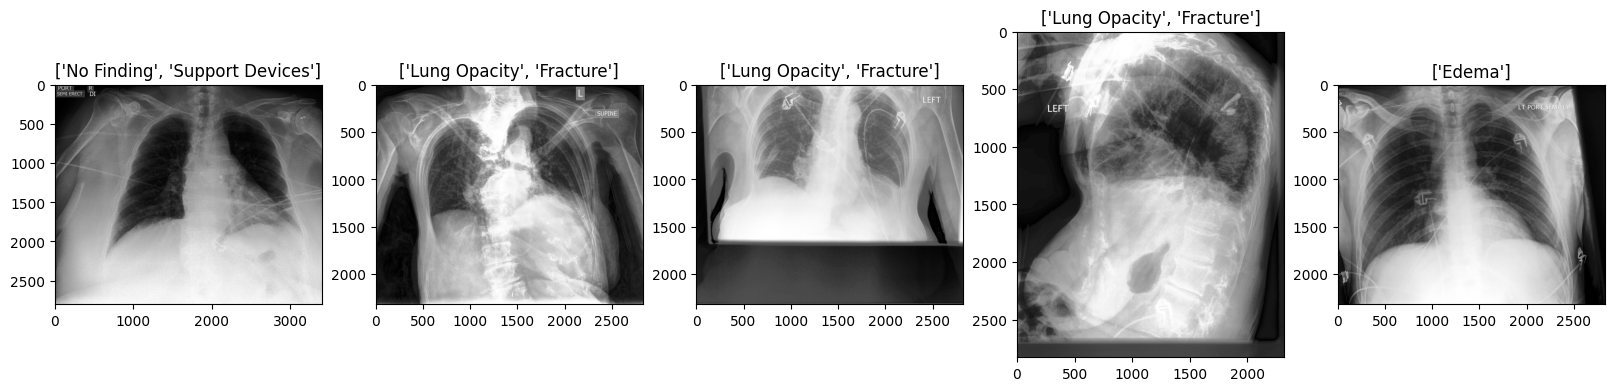

In [24]:
#get the first 5 images
paths =  full_df.path[:5]
labels = full_df.feature_string[:5]

fig, m_axs = plt.subplots(1, len(labels), figsize = (20, 10))
#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(np.asarray(Image.open(paths[ii])), cmap='gray')
    c_ax.set_title(labels[ii])
plt.show()

## Original Image

In [25]:
img = np.asarray(Image.open(X_val[0]))

In [26]:
img = np.stack((img,)*3, axis=-1)

In [27]:
img.shape

(2320, 2828, 3)

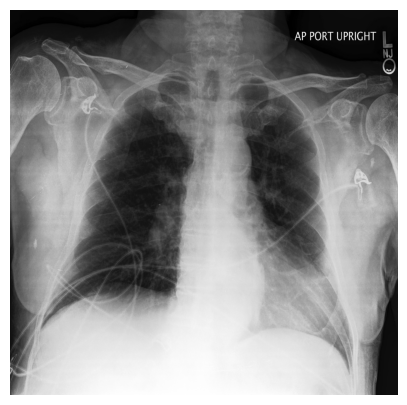

In [28]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(img)
ax.axis('off')
ax.set_aspect('auto')

plt.show() 

## Augmented Image

Most of the models test here are convolutional neural networks which have built-in translational equivariance as a result of the action of convolutional filters on the underlying image. This results in the classifier being translation invariant. However translation invariance is not the only invariance we would like our model to have, and for this reason it's important to have a large representative dataset so that many other invariances can be learned by the model during training. Augmentation is another way for us to help the model learn other invariances such as changes in brightness, saturation, contrast, etc.

In [29]:
def apply_mask(image, size=12, n_squares=1):
    h, w, channels = image.shape
    new_image = np.asarray(image.copy())
    for _ in range(n_squares):
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - size // 2, 0, h)
        y2 = np.clip(y + size // 2, 0, h)
        x1 = np.clip(x - size // 2, 0, w)
        x2 = np.clip(x + size // 2, 0, w)
        new_image[y1:y2, x1:x2, :] = 0
    return new_image

In [30]:
if np.random.uniform() < 0.5:
    augmented = apply_mask(img, size=np.random.randint(low=70, high=240), n_squares=np.random.randint(low=2, high=12))
else:
    augmented = tf.image.random_brightness(img, max_delta=0.2)
    augmented = tf.image.random_saturation(image=augmented, lower=0.8, upper=1.2)
    augmented = tf.image.random_hue(image=augmented, max_delta=0.03)
    augmented = tf.image.random_contrast(image=augmented, lower=0.8, upper=1.2)
# augmented = tf.image.random_flip_up_down(img)
# augmented = tf.image.random_flip_left_right(img)
# augmented = tf.image.random_saturation(image=img, lower=0.7, upper=1.3)
# augmented = tf.image.random_hue(image=img, max_delta=0.03)
# augmented = tf.image.random_contrast(image=img, lower=0.7, upper=1.3)

In [31]:
augmented.shape

TensorShape([2320, 2828, 3])

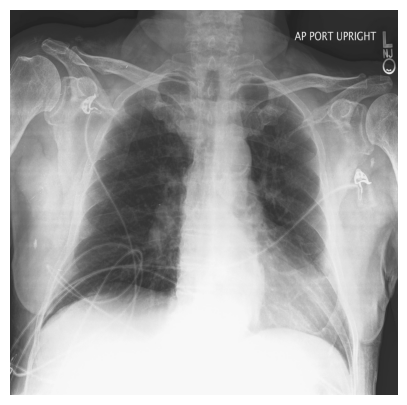

In [32]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(augmented, cmap='gray')
ax.axis('off')
ax.set_aspect('auto')

plt.show() 

In [33]:
NUM_TRAIN = len(X_train)

## Determine class weights

We often need to deal with an imbalance of classes in our dataset, especially if we want to get good recall on under represented classes. One way to do that is by using class weights so that a relatively higher loss is given on misclassifications of the under represented classes. The amount of class weighting, between none and emulating a uniform distribution, depends on the tradeoff between precision and recall for the classes. For this we will use log-scaled class weighting which will make a relatively slight adjustment toward a more uniform distribution.

In [34]:
target_columns = [col_name + '_label' for col_name in targets]

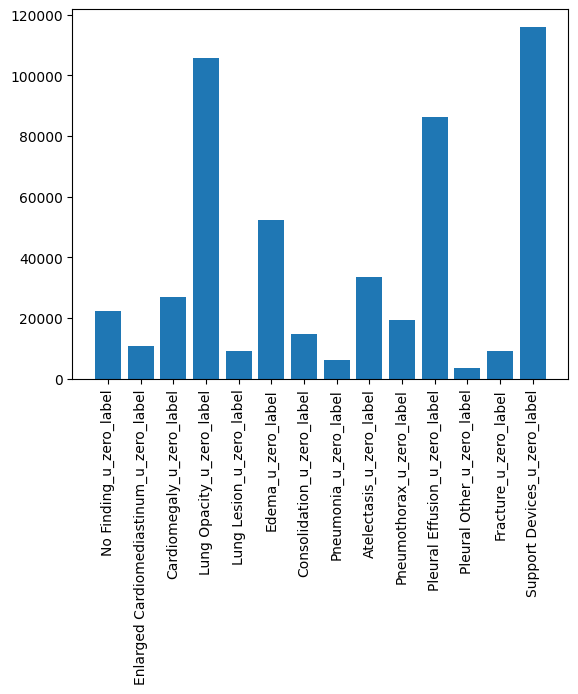

In [35]:
plt.xticks(rotation=90)
plt.bar(x=target_columns, height=y_train.sum(axis=0))
plt.show()

In [36]:
class_counts = y_train.sum(axis=0)
total_count = y_train.sum()

In [37]:
cls_weights = {i: total_count/class_i_count for i, class_i_count in enumerate(class_counts)}

In [38]:
cls_weights

{0: 23.03690630445467,
 1: 47.74856454899055,
 2: 19.09588888888889,
 3: 4.883350223998636,
 4: 56.127694317439584,
 5: 9.868487539715959,
 6: 34.8771561929243,
 7: 85.3765524093393,
 8: 15.447896692233941,
 9: 26.51115795968737,
 10: 5.982213094782276,
 11: 146.3494181095657,
 12: 57.034181415929204,
 13: 4.444694442289291}

In [39]:
cls_weights_sqrt = {i: np.sqrt(weight) for i, weight in enumerate(list(cls_weights.values()))}

In [40]:
cls_weights_sqrt

{0: 4.799677729228773,
 1: 6.91003361417226,
 2: 4.369884310698498,
 3: 2.209830360909777,
 4: 7.491841850802751,
 5: 3.1414148945524465,
 6: 5.905688460537374,
 7: 9.239943312019793,
 8: 3.9303812400623355,
 9: 5.148898713286888,
 10: 2.4458563111479537,
 11: 12.097496357080075,
 12: 7.552097815569473,
 13: 2.108244398140142}

In [41]:
cls_weights_log = {i: np.log(weight) for i, weight in enumerate(list(cls_weights.values()))}

In [42]:
cls_weights_log

{0: 3.137097551831732,
 1: 3.865949004673629,
 2: 2.9494730704653955,
 3: 1.585831505628296,
 4: 4.027629350566123,
 5: 2.289346603579213,
 6: 3.5518320645507715,
 7: 4.44707150114396,
 8: 2.7374728576513627,
 9: 3.277565699455902,
 10: 1.7887905822383254,
 11: 4.985997037110624,
 12: 4.0436507620656394,
 13: 1.4917111247108628}

In [43]:
y_train_weighted = y_train * np.array(list(cls_weights.values()))

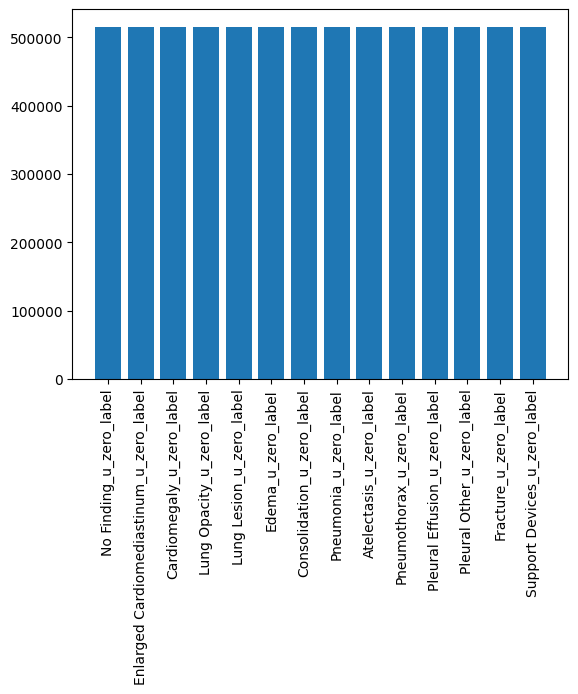

In [44]:
plt.xticks(rotation=90)
plt.bar(x=target_columns, height=y_train_weighted.sum(axis=0))
plt.show()

In [45]:
y_train_weighted_sqrt = y_train * np.array(list(cls_weights_sqrt.values()))

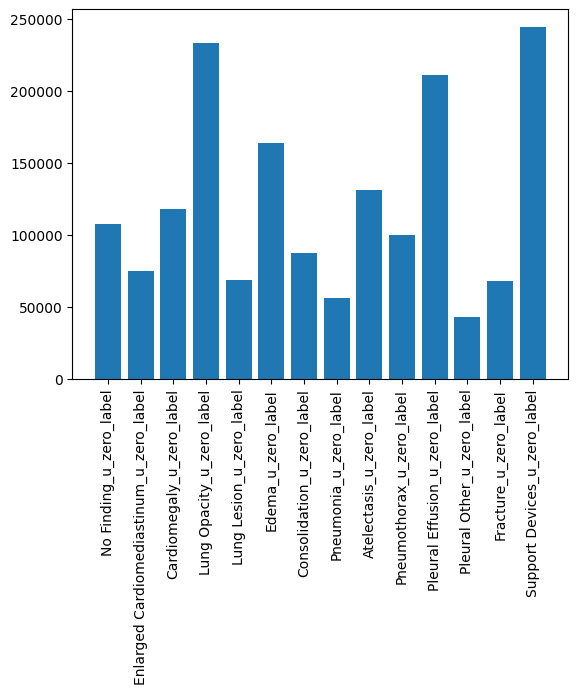

In [46]:
plt.xticks(rotation=90)
plt.bar(x=target_columns, height=y_train_weighted_sqrt.sum(axis=0))
plt.show()

In [47]:
y_train_weighted_log = y_train * np.array(list(cls_weights_log.values()))

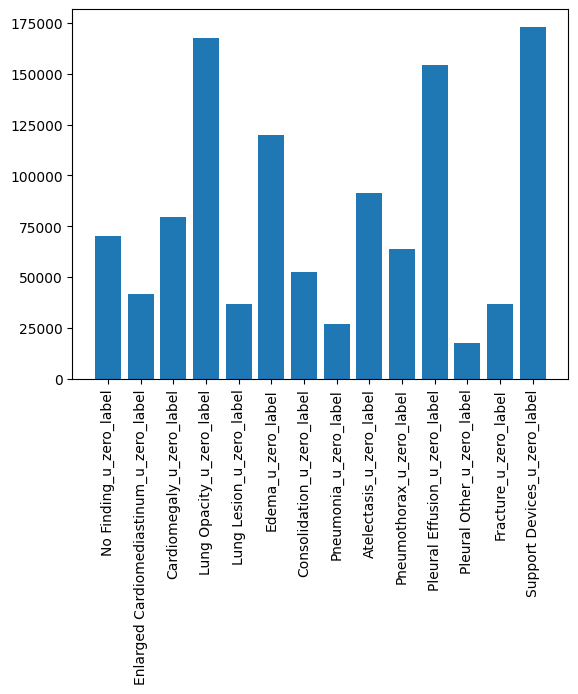

In [48]:
plt.xticks(rotation=90)
plt.bar(x=target_columns, height=y_train_weighted_log.sum(axis=0))
plt.show()

In [49]:
USE_CLASS_WEIGHTS = True

In [50]:
if USE_CLASS_WEIGHTS:
    CLASS_WEIGHTS = cls_weights_sqrt
else:
    CLASS_WEIGHTS = None

In [51]:
def convert_image_to_array(path):
    img = np.asarray(Image.open(path), dtype=np.float32)
    img = np.stack((img,)*3, axis=-1)
    img /= 255.
    img = tf.image.resize_with_pad(img, target_height=TARGET_HEIGHT, target_width=TARGET_WIDTH)
    return img

In [52]:
def create_model_file(X_path, y):
    """
    X_path: (pandas series) contains the file paths to the images
    y: (pandas series of type int) the target label
    
    return a pair of numpy arrays representing (features, target)
    """
    
    X = pd.Series(X_path).apply(convert_image_to_array)
    X = X.values
    X = list(X)
    X = np.array(X, dtype='float32')
    
    return (X, y)

In [53]:
def model_predict(path, model):
    x = convert_image_to_array(path=path)
    x = np.expand_dims(x, axis=0)
    return model.predict(x)

In [54]:
val_data = create_model_file(X_path=X_val, y=y_val)

In [55]:
val_data[0].shape

(234, 640, 640, 3)

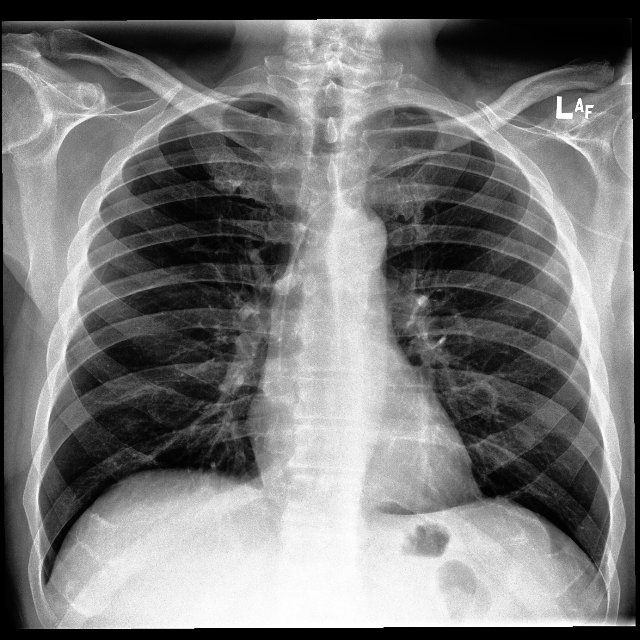

In [56]:
Image.fromarray(np.uint8(255 * val_data[0][1]))

Create a data generator for training

In [57]:
num_classes = y_train.shape[1]

In [58]:
def data_gen(X, y, batch_size, image_size=(TARGET_HEIGHT, TARGET_WIDTH), dtype=np.float32, scale_image=True):
    # Get total number of samples in the data
    n = len(X)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, image_size[0], image_size[1], 3), dtype=dtype)
    batch_labels = np.zeros((batch_size, num_classes), dtype=dtype)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i = 0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_path = X[idx]
            label = y[idx]
            
            # one hot encoding
            encoded_label = label
            # read the image
            img = np.asarray(Image.open(img_path), dtype=dtype)
            img = np.stack((img,)*3, axis=-1)
            
            # add image augmentation
            if np.random.uniform() < 0.65:
                img = apply_mask(img, size=np.random.randint(low=70, high=240), n_squares=np.random.randint(low=2, high=12))
            else:
                if np.random.uniform() < 0.15:
                    img = tf.image.random_brightness(img, max_delta=0.2)
                if np.random.uniform() < 0.15:
                    img = tf.image.random_saturation(image=img, lower=0.8, upper=1.2)
                if np.random.uniform() < 0.15:
                    img = tf.image.random_hue(image=img, max_delta=0.03)
                if np.random.uniform() < 0.15:
                    img = tf.image.random_contrast(image=img, lower=0.8, upper=1.2)
            
            if scale_image:
                img = img/255.
            
            # resize image
            img = tf.image.resize_with_pad(img, target_height=image_size[0], target_width=image_size[1])
            
            batch_data[count] = img
            batch_labels[count] = encoded_label

            count+=1

            if count==batch_size:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

## Keras Utility Functions

Define some functions that will help simplify the fine-tuning pre-trained models

In [59]:
def freeze_layers(model, freeze_layer_name):
    for layer in model.layers:
        if layer.name != freeze_layer_name:
            layer.trainable = False
        else:
            layer.trainable = False
            break
            
def unfreeze_batch_norm(model):
    for layer in model.layers:
        if layer.__class__.__name__ == 'BatchNormalization':
            layer.trainable = True
            
def unfreeze_layer_norm(model):
    for layer in model.layers:
        if layer.__class__.__name__ == 'LayerNormalization':
            layer.trainable = True

def print_layer_trainable(model):
    for layer in model.layers:
        print('{0}:\t{1}'.format(layer.trainable, layer.name))

## Build the model

TODO Add in MobileNetV2, EfficientNet (this requires tensorflow 2.2 nightly update import once this is in stable release), DenseNet

In [ ]:
# from tensorflow.keras.applications.xception import Xception

# input_tensor = layers.Input(shape=(450, 600, 3), name='ImageInput')

# model = Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [ ]:
# Note: Expected input from B5, B6, B7 are 456x456, 528x528, 600x600
# from tensorflow.python.keras.applications.efficientnet import EfficientNetB6

# input_tensor = layers.Input(shape=(TARGET_HEIGHT, TARGET_WIDTH, 3), name='ImageInput')

# model = EfficientNetB6(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [ ]:
# from tensorflow.keras.applications.resnet_v2 import ResNet101V2

# input_tensor = layers.Input(shape=(TARGET_HEIGHT, TARGET_WIDTH, 3), name='ImageInput')

# model = ResNet101V2(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [ ]:
# from tensorflow.keras.applications.densenet import DenseNet201

# input_tensor = layers.Input(shape=(TARGET_HEIGHT, TARGET_WIDTH, 3), name='ImageInput')

# model = DenseNet201(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [ ]:
# from tensorflow.keras.applications import ConvNeXtSmall

# input_tensor = layers.Input(shape=(TARGET_HEIGHT, TARGET_WIDTH, 3), name='ImageInput')

# model = ConvNeXtSmall(include_top=False, weights='imagenet', input_tensor=input_tensor, include_preprocessing=False)

In [60]:
from tensorflow.keras.applications import ConvNeXtBase

input_tensor = layers.Input(shape=(TARGET_HEIGHT, TARGET_WIDTH, 3), name='ImageInput')

# model = ConvNeXtBase(include_top=False, weights='imagenet', input_tensor=input_tensor, include_preprocessing=False)
model = ConvNeXtBase(include_top=False, weights='imagenet', input_tensor=input_tensor, include_preprocessing=True)

350926856/350926856 [==============================] - 11s 0us/step


In [61]:
model.summary()

Model: "convnext_base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageInput (InputLayer)        [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_base_prestem_normaliz  (None, 640, 640, 3)  0          ['ImageInput[0][0]']             
 ation (Normalization)                                                                            
                                                                                                  
 convnext_base_stem (Sequential  (None, 160, 160, 12  6528       ['convnext_base_prestem_normaliza
 )                              8)                               tion[0][0]']         

 tf.__operators__.add_2 (TFOpLa  (None, 160, 160, 12  0          ['tf.__operators__.add_1[0][0]', 
 mbda)                          8)                                'convnext_base_stage_0_block_2_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_base_downsampling_blo  (None, 80, 80, 256)  131584     ['tf.__operators__.add_2[0][0]'] 
 ck_0 (Sequential)                                                                                
                                                                                                  
 convnext_base_stage_1_block_0_  (None, 80, 80, 256)  12800      ['convnext_base_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_0[0][0]']                      
                                                                                                  
 convnext_

 convnext_base_downsampling_blo  (None, 40, 40, 512)  525312     ['tf.__operators__.add_5[0][0]'] 
 ck_1 (Sequential)                                                                                
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 40, 40, 512)  25600      ['convnext_base_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_1[0][0]']                      
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_0_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_0_l
 pointwise

 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_3_l
 pointwise_conv_1 (Dense)       )                                ayernorm[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_3_p
 gelu (Activation)              )                                ointwise_conv_1[0][0]']          
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_3_g
 pointwise_conv_2 (Dense)                                        elu[0][0]']                      
          

 convnext_base_stage_2_block_6_  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_6_g
 pointwise_conv_2 (Dense)                                        elu[0][0]']                      
                                                                                                  
 convnext_base_stage_2_block_6_  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_6_p
 layer_scale (LayerScale)                                        ointwise_conv_2[0][0]']          
                                                                                                  
 convnext_base_stage_2_block_6_  (None, 40, 40, 512)  0          ['convnext_base_stage_2_block_6_l
 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_12 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_11[0][0]',
 ambda)   

                                                                                                  
 tf.__operators__.add_15 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_14[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_9_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_base_stage_2_block_10  (None, 40, 40, 512)  25600      ['tf.__operators__.add_15[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_base_stage_2_block_10  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_10_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )        

 convnext_base_stage_2_block_13  (None, 40, 40, 512)  25600      ['tf.__operators__.add_18[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_base_stage_2_block_13  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_13_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )                                                                                                
                                                                                                  
 convnext_base_stage_2_block_13  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_13_
 _pointwise_conv_1 (Dense)      )                                layernorm[0][0]']                
                                                                                                  
 convnext_

 )                                                                                                
                                                                                                  
 convnext_base_stage_2_block_16  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_16_
 _pointwise_conv_1 (Dense)      )                                layernorm[0][0]']                
                                                                                                  
 convnext_base_stage_2_block_16  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_16_
 _gelu (Activation)             )                                pointwise_conv_1[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_16  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_16_
 _pointwise_conv_2 (Dense)                                       gelu[0][0]']                     
          

 convnext_base_stage_2_block_19  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_19_
 _gelu (Activation)             )                                pointwise_conv_1[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_19  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_19_
 _pointwise_conv_2 (Dense)                                       gelu[0][0]']                     
                                                                                                  
 convnext_base_stage_2_block_19  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_19_
 _layer_scale (LayerScale)                                       pointwise_conv_2[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_19  (None, 40, 40, 512)  0          ['convnext_base_stage_2_block_19_
 _identity

                                                                                                  
 convnext_base_stage_2_block_22  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_22_
 _layer_scale (LayerScale)                                       pointwise_conv_2[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_22  (None, 40, 40, 512)  0          ['convnext_base_stage_2_block_22_
 _identity (Activation)                                          layer_scale[0][0]']              
                                                                                                  
 tf.__operators__.add_28 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_27[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_22_
                                                                 identity[0][0]']                 
          

 _identity (Activation)                                          layer_scale[0][0]']              
                                                                                                  
 tf.__operators__.add_31 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_30[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_25_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_26  (None, 40, 40, 512)  25600      ['tf.__operators__.add_31[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_base_stage_2_block_26  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_26_
 _layernor

 ambda)                         )                                 'convnext_base_stage_3_block_1_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 20, 20, 1024  51200      ['tf.__operators__.add_34[0][0]']
 depthwise_conv (Conv2D)        )                                                                 
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 20, 20, 1024  2048       ['convnext_base_stage_3_block_2_d
 layernorm (LayerNormalization)  )                               epthwise_conv[0][0]']            
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 20, 20, 4096  4198400    ['convnext_base_stage_3_block_2_l
 pointwise

## Load Pretrained Model (alternative)

In [ ]:
# model_path='./serialized_models/pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.3887.h5'
# model_path='./serialized_models/pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.4021.h5'
# model_path='./serialized_models/pretrain_model_ConvNeXtSmall_w_ClssWgt_03-0.5216.h5'

In [ ]:
# from keras.applications.convnext import LayerScale
# model = tf.keras.models.load_model(model_path, custom_objects={'LayerScale': LayerScale})

Determine where to freeze and cut off base model

In [ ]:
# Note: these were used to train Xception
# transfer_layer_name = 'block14_sepconv1_act'
# freeze_layer_name = 'add_10'

# transfer_layer = model.get_layer(transfer_layer_name)

In [ ]:
# Note: these were used to train EfficientNet
# transfer_layer_name = 'block7c_add'
# freeze_layer_name = 'block6k_add'

# transfer_layer = model.get_layer(transfer_layer_name)

In [ ]:
# Note: these were used to train ResNet101V2
# transfer_layer_name = 'post_relu'
# freeze_layer_name = 'conv5_block1_out'

# transfer_layer = model.get_layer(transfer_layer_name)

In [ ]:
# Note: these were used to train DenseNet201
# transfer_layer_name = 'relu'
# # freeze_layer_name = 'conv5_block27_concat'

# transfer_layer = model.get_layer(transfer_layer_name)

In [ ]:
# # Note: these were used to train ConvNeXtSmall
# transfer_layer_name = 'layer_normalization'
# freeze_layer_name = 'tf.__operators__.add_33'

# transfer_layer = model.get_layer(transfer_layer_name)

In [62]:
# # Note: these were used to train ConvNeXtBase
transfer_layer_name = 'layer_normalization'
# freeze_layer_name = 'tf.__operators__.add_21' # tf.__operators__.add_17, tf.__operators__.add_21, tf.__operators__.add_26, tf.__operators__.add_31
# consider using smaller input image 512 x 512 and retrain more 
transfer_layer = model.get_layer(transfer_layer_name)

In [63]:
# model.summary()

In [64]:
conv_model = tf.keras.Model(inputs=model.input, outputs=transfer_layer.output)

In [65]:
def build_model(base_model, num_classes, pooling='avg', final_conv_layer='vgg_separable', expand_model=True, dropout_rate=0):
    # Get the output of the base model on which we will build
    x = base_model.layers[-1].output
    
    if expand_model:
        if final_conv_layer == 'xception':
            x = layers.SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
            x = layers.BatchNormalization(name='block14_sepconv2_bn')(x)
            x = layers.Activation('relu', name='block14_sepconv2_act')(x)
        elif final_conv_layer == 'non_separable':
            x = layers.Conv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_conv2')(x)
            x = layers.BatchNormalization(name='block14_conv2_bn')(x)
            x = layers.Activation('relu', name='block14_conv2_act')(x)
        elif final_conv_layer == 'vgg_separable':
            x = layers.SeparableConv2D(2048, (3,3), activation='relu', padding='same', name='block14_sepconv2')(x)
        elif final_conv_layer == 'vgg':
            x = layers.Conv2D(2048, (3,3), activation='relu', padding='same', name='block14_sepconv2')(x)
        else:
            raise ValueError('`final_conv_layer` should be one of the following: xception, non_separable, vgg_separable, or vgg')

    if pooling == 'global_avg':
        x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    elif pooling == 'global_max':
        x = layers.GlobalMaxPooling2D(name='global_max_pool')(x)
    elif pooling == 'max':
        x = layers.MaxPooling2D((2,2), name='local_max_pool')(x)
        x = layers.Flatten(name='flatten')(x)
    elif pooling == 'avg':
        x = layers.AveragePooling2D((2,2), name='local_avg_pool')(x)
        x = layers.Flatten(name='flatten')(x)
    else:
        pass
    x = keras.layers.Dropout(dropout_rate)(x)
        
    x = layers.Dense(num_classes, activation='sigmoid', name='prediction')(x)

    # Create model.
    model = tf.keras.Model(base_model.input, x, name='Xception')
    return model

## Determine good starting learning rate

Experiment with the proper learning rate range by starting at a low number, see how many epochs for loss to get to a certain value, incrementally increase until the learning rate is too high. Use this range to determine the initial learning rate.

Create a function to do this analysis

In [ ]:
def determine_learning_rate(X, y, batch_size: int, lr_list: List[float], steps: int):
    train_loss_by_lr = []
    
    for i, lr in enumerate(lr_list):
        print(f'Learning rate {i + 1} of {len(lr_list)}. LR value: {lr}')
        local_model = ConvNeXtBase(include_top=False, weights='imagenet', input_tensor=input_tensor, include_preprocessing=False)
        local_conv_model = tf.keras.Model(inputs=local_model.input, outputs=local_model.output)
        
        model_lr = build_model(base_model=local_conv_model, num_classes=num_classes, dropout_rate=0.3)
        
        model_lr.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss="binary_crossentropy",
            metrics=["accuracy"],
        )
        
        hist = model_lr.fit(
            x=data_gen(X=X, y=y, batch_size=batch_size, scale_image=False), 
            epochs=1, 
            steps_per_epoch=steps,
            class_weight=CLASS_WEIGHTS,
        )
        
        final_loss = hist.history['loss'][-1]
        final_acc = hist.history['accuracy'][-1]
        
        train_loss_by_lr.append((lr, final_loss, final_acc))
      
    losses_df = pd.DataFrame(train_loss_by_lr, columns=['learning_rate', 'training_loss', 'training_accuracy'])
    
    return losses_df

In [ ]:
lr_loss_df = determine_learning_rate(X=X_train, 
                                     y=y_train, 
                                     batch_size=2, 
                                     lr_list=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 1e-7, 1e-8,],
                                     steps=200)

In [ ]:
# plt.scatter(x=lr_loss_df['learning_rate'].values, y=lr_loss_df['training_loss'].values)
# plt.xscale('log')
# plt.show()

## Train model

In [ ]:
# Ideally retrain the entire model, but memory is constrained 
# freeze_layers(conv_model, freeze_layer_name)

In [66]:
model = build_model(base_model=conv_model, num_classes=num_classes, dropout_rate=0.3)

In [67]:
# model.summary()

In [68]:
unfreeze_batch_norm(model)

In [69]:
unfreeze_layer_norm(model)

In [70]:
print_layer_trainable(model)

True:	ImageInput
True:	convnext_base_prestem_normalization
True:	convnext_base_stem
True:	convnext_base_stage_0_block_0_depthwise_conv
True:	convnext_base_stage_0_block_0_layernorm
True:	convnext_base_stage_0_block_0_pointwise_conv_1
True:	convnext_base_stage_0_block_0_gelu
True:	convnext_base_stage_0_block_0_pointwise_conv_2
True:	convnext_base_stage_0_block_0_layer_scale
True:	convnext_base_stage_0_block_0_identity
True:	tf.__operators__.add
True:	convnext_base_stage_0_block_1_depthwise_conv
True:	convnext_base_stage_0_block_1_layernorm
True:	convnext_base_stage_0_block_1_pointwise_conv_1
True:	convnext_base_stage_0_block_1_gelu
True:	convnext_base_stage_0_block_1_pointwise_conv_2
True:	convnext_base_stage_0_block_1_layer_scale
True:	convnext_base_stage_0_block_1_identity
True:	tf.__operators__.add_1
True:	convnext_base_stage_0_block_2_depthwise_conv
True:	convnext_base_stage_0_block_2_layernorm
True:	convnext_base_stage_0_block_2_pointwise_conv_1
True:	convnext_base_stage_0_block_2_

## Train the model

In [71]:
lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
      # initial_learning_rate=3e-3, # for uniform weighting
      initial_learning_rate=3e-4, # for sqrt weighting 
      first_decay_steps=7979)

In [72]:
# Cycle through cosine decay with restarts 7 times per epoch
7979 == 55853 / 7

True

In [73]:
epochs = 20
batch_size = 4
model_path='../models/pretrain_model_ConvNeXtBase_w_ClssWgt_{epoch:02d}-{val_loss:.4f}.h5'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=model_path, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3),
    tf.keras.callbacks.EarlyStopping(patience=10)
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    x=data_gen(X=X_train, y=y_train, batch_size=batch_size, scale_image=False), 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_data=val_data, 
    steps_per_epoch=int(NUM_TRAIN/batch_size),
    class_weight=CLASS_WEIGHTS,
)

Epoch 1/20
 7364/55853 [==>...........................] - ETA: 8:21:05 - loss: 1.2744 - accuracy: 0.0874

KeyboardInterrupt: 

13300/55853, loss: 0.3006, accuracy: 0.2011
7364/55853, loss: 1.2744, accuracy: 0.0874 (using built-in preprocessing rather than scaling)

Save final model - Make sure name is correct!

In [ ]:
model.save('./serialized_models/pretrain_model_ConvNeXtBase_w_ClssWgt_04-0.4061.h5')

## Evaluate model performance

### TODO
- Move all these utility function to a python script instead

Load specific model (optional)

In [ ]:
from keras.applications.convnext import LayerScale

In [ ]:
model_path='./serialized_models/pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.3616.h5'

In [ ]:
model = tf.keras.models.load_model(model_path, custom_objects={'LayerScale': LayerScale})

In [ ]:
MODEL_NAME = 'pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.3616.h5'

Get all predictions

In [ ]:
pred_columns = [col_name + '_pred' for col_name in targets]
target_columns = [col_name + '_label' for col_name in targets]

In [ ]:
all_model_preds = pd.DataFrame(0, index=np.arange(len(X_val)), columns=pred_columns)

In [ ]:
for i, path in enumerate(X_val):
    all_model_preds.iloc[i, :] = model_predict(path=path, model=model)[0]

In [ ]:
all_model_preds

In [ ]:
results = pd.DataFrame(data=y_val, columns=target_columns)

In [ ]:
results

In [ ]:
results = pd.concat([results, all_model_preds], axis=1)

In [ ]:
y = results[target_columns].values
pred = results[pred_columns].values

In [ ]:
plt.xticks(rotation=90)
plt.bar(x = target_columns, height= y.sum(axis=0))
plt.show()

In [ ]:
def true_positives(y, pred, th=0.5):
    """
    Count true positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TP (int): true positives
    """
    TP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    # compute TP
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    
    return TP

def true_negatives(y, pred, th=0.5):
    """
    Count true negatives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TN (int): true negatives
    """
    TN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th
    
    # compute TN
    TN = np.sum((y == 0) & (thresholded_preds == 0))
    
    return TN

def false_positives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FP (int): false positives
    """
    FP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    # compute FP
    FP = np.sum((y == 0) & (thresholded_preds == 1))
    
    return FP

def false_negatives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FN (int): false negatives
    """
    FN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th
    
    # compute FN
    FN = np.sum((y == 1) & (thresholded_preds == 0))
    
    return FN

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)


def get_true_pos(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def get_true_neg(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def get_false_neg(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def get_false_pos(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))


def get_performance_metrics(y, pred, class_labels, tp=get_true_pos,
                            tn=get_true_neg, fp=get_false_pos,
                            fn=get_false_neg,
                            acc=None, prevalence=None, spec=None,
                            sens=None, ppv=None, npv=None, auc=None, f1=None,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.iloc[i, 0] = class_labels[i]
        df.iloc[i, 1] = round(tp(y[:, i], pred[:, i]),
                             3) if tp != None else "Not Defined"
        df.iloc[i, 2] = round(tn(y[:, i], pred[:, i]),
                             3) if tn != None else "Not Defined"
        df.iloc[i, 3] = round(fp(y[:, i], pred[:, i]),
                             3) if fp != None else "Not Defined"
        df.iloc[i, 4] = round(fn(y[:, i], pred[:, i]),
                             3) if fn != None else "Not Defined"
        df.iloc[i, 5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.iloc[i, 6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.iloc[i, 7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.iloc[i, 8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.iloc[i, 9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.iloc[i, 10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        try:
            df.iloc[i, 11] = round(auc(y[:, i], pred[:, i]),
                                  3) if auc != None else "Not Defined"
        except:
            df.iloc[i, 11] = np.NAN
        df.iloc[i, 12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.iloc[i, 13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df


def print_confidence_intervals(class_labels, statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    for i in range(len(class_labels)):
        mean = statistics.mean(axis=1)[i]
        max_ = np.quantile(statistics, .95, axis=1)[i]
        min_ = np.quantile(statistics, .05, axis=1)[i]
        df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df


def get_curve(gt, pred, target_names, curve='roc'):
    for i in range(len(target_names)):
        if curve == 'roc':
            curve_function = roc_curve
            auc_roc = roc_auc_score(gt[:, i], pred[:, i])
            label = target_names[i] + " AUC: %.3f " % auc_roc
            xlabel = "False positive rate"
            ylabel = "True positive rate"
            a, b, _ = curve_function(gt[:, i], pred[:, i])
            plt.figure(1, figsize=(7, 7))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(a, b, label=label)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        elif curve == 'prc':
            precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
            average_precision = average_precision_score(gt[:, i], pred[:, i])
            label = target_names[i] + " Avg.: %.3f " % average_precision
            plt.figure(1, figsize=(7, 7))
            plt.step(recall, precision, where='post', label=label)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)

In [ ]:
get_performance_metrics(y, pred, target_columns)

In [ ]:
def get_accuracy(y, pred, th=0.5):
    """
    Compute accuracy of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        accuracy (float): accuracy of predictions at threshold
    """
    accuracy = 0.0
    
    # get TP, FP, TN, FN using our previously defined functions
    TP = true_positives(y, pred, th)
    FP = false_positives(y, pred, th)
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)

    # Compute accuracy using TP, FP, TN, FN
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    return accuracy

In [ ]:
get_performance_metrics(y, pred, target_columns, acc=get_accuracy)

In [ ]:
def get_prevalence(y):
    """
    Compute accuracy of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
    Returns:
        prevalence (float): prevalence of positive cases
    """
    prevalence = 0.0
    
    prevalence = np.sum(y) / len(y)
    
    return prevalence

In [ ]:
get_performance_metrics(y, pred, target_columns, acc=get_accuracy, prevalence=get_prevalence)

In [ ]:
def get_sensitivity(y, pred, th=0.5):
    """
    Compute sensitivity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        sensitivity (float): probability that our test outputs positive given that the case is actually positive
    """
    sensitivity = 0.0
    
    # get TP and FN using our previously defined functions
    TP = true_positives(y, pred, th)
    FN = false_negatives(y, pred, th)

    # use TP and FN to compute sensitivity
    sensitivity = TP / (TP + FN)
    
    return sensitivity

def get_specificity(y, pred, th=0.5):
    """
    Compute specificity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        specificity (float): probability that the test outputs negative given that the case is actually negative
    """
    specificity = 0.0
    
    # get TN and FP using our previously defined functions
    TN = true_negatives(y, pred, th)
    FP = false_positives(y, pred, th)
    
    # use TN and FP to compute specificity 
    specificity = TN / (TN + FP)
    
    return specificity

In [ ]:
get_performance_metrics(y, pred, target_columns, acc=get_accuracy, prevalence=get_prevalence, sens=get_sensitivity, spec=get_specificity)

In [ ]:
def get_ppv(y, pred, th=0.5):
    """
    Compute PPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        PPV (float): positive predictive value of predictions at threshold
    """
    PPV = 0.0
    
    # get TP and FP using our previously defined functions
    TP = true_positives(y, pred, th)
    FP = false_positives(y, pred, th)

    # use TP and FP to compute PPV
    PPV = TP / (TP + FP)
    
    return PPV

def get_npv(y, pred, th=0.5):
    """
    Compute NPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        NPV (float): negative predictive value of predictions at threshold
    """
    NPV = 0.0
    
    # get TN and FN using our previously defined functions
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)

    # use TN and FN to compute NPV
    NPV = TN / (TN + FN)
    
    return NPV

In [ ]:
get_performance_metrics(y, pred, target_columns, acc=get_accuracy, prevalence=get_prevalence, sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv)

In [ ]:
# get_curve(y, pred, target_columns)

In [ ]:
from sklearn.metrics import roc_auc_score
get_performance_metrics(y, pred, target_columns, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score)

In [ ]:
def bootstrap_auc(y, pred, classes, bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))

    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            try:
                score = roc_auc_score(y_sample, pred_sample)
            except:
                score = 0
            statistics[c][i] = score
    return statistics

statistics = bootstrap_auc(y, pred, target_columns)

In [ ]:
print_confidence_intervals(target_columns, statistics)

In [ ]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y, pred):
    plt.figure(figsize=(20, 20))
    for i in range(len(target_columns)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y[:,i], pred[:,i], n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(target_columns[i])
    plt.tight_layout()
    plt.show()

In [ ]:
plot_calibration_curve(y, pred)

In [ ]:
from sklearn.metrics import f1_score
model_performance_df = get_performance_metrics(y, pred, target_columns, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
model_performance_df

In [ ]:
model_performance_df.to_csv(f'model_performance/test_metrics_{MODEL_NAME}.csv')

In [ ]:
print_confidence_intervals(target_columns, statistics)

## Define Grad-CAM Algorithm

In [ ]:
X_test.head(15)

In [ ]:
MY_IMG_PATH = X_test[6]

In [ ]:
MY_IMG_PATH

In [ ]:
# DenseNet201, Xception
last_conv_layer_name = 'block14_sepconv2'
classifier_layer_names = ['local_avg_pool', 'flatten', 'prediction']

Run model on a single image

In [ ]:
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
test_num = 9

X_test_example = X_test[test_num]
y_test_example = y_test[test_num]

y_hat = model_predict(path=X_test_example, model=model)

print(f'Ground truth label: {y_test_example} \n Predicted label: {np.argmax(y_hat)} \t Probability: {np.max(y_hat)}')

Run model on the entire test set

In [ ]:
test_data = create_model_file(X_path=X_test, y=y_test)

In [ ]:
model.evaluate(x=test_data[0], y=test_data[1])

In [ ]:
# # EfficientNetV2S
# last_conv_layer_name = 'top_conv'
# classifier_layer_names = ['top_bn', 'top_activation', 'local_avg_pool', 'flatten', 'prediction']

In [ ]:
def get_img_array(img_path):
    img = convert_image_to_array(path=img_path)
    # We add a dimension to transform our array into a "batch"
    img = np.expand_dims(img, axis=0)
    return img


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

First look at active regions

In [ ]:
# Prepare image
img_array = get_img_array(img_path=MY_IMG_PATH)

# Print what the top predicted class is
preds = model.predict(img_array)
pred_class = np.argmax(preds)
pred_label = 'normal' if pred_class == 0 else 'nodule'
pred_prob = np.max(preds)
#print(f"Predicted class: {pred_label} \n Probability: {pred_prob} \n Actual Class: {lesion_type_dict[label_abbreviation]}")
print(f"Predicted class: {pred_label} \n Probability: {pred_prob}")

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Overlay the heatmap on the original image

In [ ]:
# We load the original image
#img = np.asarray(Image.open(SAMPLE_PATH))
img = convert_image_to_array(path=MY_IMG_PATH)
# img = np.expand_dims(img, axis=0)
# img = img.squeeze()
img = np.uint8(255. * img)
# img = np.uint8(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255. * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.2 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "heatmap.jpg"
superimposed_img.save(save_path)

# Display Grad CAM along with original image
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

axs[0].imshow(np.asarray(Image.open(save_path)))
axs[0].axis('off')
axs[0].set_aspect('auto')
#axs[1].imshow(np.asarray(Image.open(SAMPLE_PATH)))
# axs[1].imshow(np.asarray(Image.open(MY_IMG_PATH)))
axs[1].imshow(np.asarray(img))
axs[1].axis('off')
axs[1].set_aspect('auto')

plt.show() 